## Extra : Solve the LunarLander-v2 
--------
Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

------
* Using the DQN to solve this problem using the experience relay and fully connected network


In [2]:
import tensorflow as tf
import gym
import os
import numpy as np
import random
import tensorflow.contrib.slim as slim
from gym.wrappers import Monitor

env = gym.make('LunarLander-v2')
path = "./dqn" #The path to save our model to.
if not os.path.exists(path):
    os.makedirs(path)
num_episodes = 1000
#Whether capture the video
#----------------------------
#env = Monitor((env),directory="./dqn",video_callable=lambda count: count % 100 == 0, write_upon_reset=True,force=True)

from gym.wrappers import Monitor
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])


batch_size = 50 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
annealing_steps = 10000. #How many steps of training to reduce startE to endE.
num_episodes = 5000 #How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
max_epLength = 2000 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
path = "./dqn" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network


class SingleQnetwork():
    def __init__(self,h_size):
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        #We use slim.conv2d to set up our network 
        self.scalarInput =  tf.placeholder(shape=[None,8],dtype=tf.float32)
        xavier_init = tf.contrib.layers.xavier_initializer()  
        W1 = tf.Variable(xavier_init([8,512]))
        b1=tf.Variable(0.0,name='b1')
        W2 = tf.Variable(xavier_init([512,h_size]))
        b2=tf.Variable(0.0,name='b2')
        # hidden layers
        self.fc1= tf.nn.relu(tf.matmul(self.scalarInput,W1) + b1)
        # Q Value layer
        self.fc2= tf.nn.relu(tf.matmul(self.fc1,W2)+ b2)
        W = tf.Variable(xavier_init([h_size,4]))
     
        b=tf.Variable(0.0,name='b')
       
        self.Qout =tf.matmul(slim.flatten( self.fc2),W)+b
    
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,4,dtype=tf.float32)
        
        predQ=tf.reduce_sum((self.Qout*self.actions_onehot),axis=1)  #advangtage of choosing predicted action
        self.loss=tf.reduce_mean(tf.squared_difference(self.targetQ,predQ))      
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)
        
    




tf.reset_default_graph()
mainQN = SingleQnetwork(h_size)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
trainables = tf.trainable_variables()

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/annealing_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)
with tf.device('/gpu:0'):
    with tf.Session() as sess:
        sess.run(init)
        if load_model == True:
            print('Loading Model...')
            ckpt = tf.train.get_checkpoint_state(path)
            saver.restore(sess,ckpt.model_checkpoint_path)
        for i in range(num_episodes):
            episodeBuffer = experience_buffer()
            #Reset environment and get first new observation
            s = env.reset()
   
            d = False
            rAll = 0
            j = 0
            #The Q-Network
            while j < max_epLength: #If the agent takes longer than 50 moves to reach either of the blocks, end the trial.
                j+=1
                #Choose an action by greedily (with e chance of random action) from the Q-network
                if np.random.rand(1) < e or total_steps < pre_train_steps:
                    a = np.random.randint(0,4)
                else:
                    a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.reshape(np.array(s),[-1,8])})[0]
                total_steps += 1
                s1,r,d,_=env.step(a)
         
                episodeBuffer.add(np.array([s,a,r,s1,d]).reshape(1,5))

                if total_steps > pre_train_steps:
                    if e > endE:
                        e -= stepDrop

                    if total_steps % (update_freq) == 0:


                        train_batch=myBuffer.sample(batch_size)
                        cur_state=np.vstack(train_batch[:,0])
                        action_batch=train_batch[:,1]
                        r_batch=train_batch[:,2]
                        next_state=np.vstack(train_batch[:,3])

                        #select the predicted action
                        Qout,predict=sess.run([mainQN.Qout,mainQN.predict],feed_dict={mainQN.scalarInput:next_state})
                       
                        #calculate Q-values for next state
                        #select the value for updating
                        Qpredict=Qout[range(batch_size),predict]

                        mask= -(train_batch[:,4] - 1)  
                        targetQ =r_batch+(y*Qpredict*mask)

                        loss,_=sess.run([mainQN.loss,mainQN.updateModel] ,feed_dict={mainQN.scalarInput:cur_state,mainQN.actions:action_batch,mainQN.targetQ:targetQ})
                        #if i % 100 == 0:
                            #print(loss)
                rAll += r
                s = s1

                if d == True:
                    break

            myBuffer.add(episodeBuffer.buffer)
            jList.append(j)
            rList.append(rAll)
            
            #Periodically save the model. 
            if i % 1000 == 0:
                saver.save(sess,path+'/model-'+str(i)+'.ckpt')
                print("Saved Model")
            if len(rList) % 10 == 0:
                print("Episode",i,"reward:",np.mean(rList[-10:]))
                if(np.mean(rList[-10:])>=200):
                    print('Task Complete,reward: ', np.mean(rList[-10:]))
                    break
        saver.save(sess,path+'/model-'+str(i)+'.ckpt')
print("Real episode: " ,i )

[2017-12-01 15:37:58,812] Making new env: LunarLander-v2
[2017-12-01 15:37:58,873] Clearing 26 monitor files from previous run (because force=True was provided)


Loading Model...
INFO:tensorflow:Restoring parameters from ./dqn/model-0.ckpt


[2017-12-01 15:37:59,433] Restoring parameters from ./dqn/model-0.ckpt
[2017-12-01 15:37:59,457] Starting new video recorder writing to /Users/cheriewang/Desktop/SRTP/openaigym.video.0.498.video000000.mp4


Saved Model
Episode 9 reward: -230.438692021
Episode 19 reward: -233.371149869
Episode 29 reward: -254.907113806
Episode 39 reward: -302.436482756
Episode 49 reward: -202.264671385
Episode 59 reward: -278.709826842
Episode 69 reward: -245.303093906
Episode 79 reward: -219.779164558


[2017-12-01 15:38:04,201] Starting new video recorder writing to /Users/cheriewang/Desktop/SRTP/openaigym.video.0.498.video000100.mp4


Episode 89 reward: -188.694865063
Episode 99 reward: -207.626461367
Episode 109 reward: -231.90454562
Episode 119 reward: -289.935099404
Episode 129 reward: -251.398033506
Episode 139 reward: -219.922521614
Episode 149 reward: -206.923378492
Episode 159 reward: -245.209141309
Episode 169 reward: -427.297580459
Episode 179 reward: -84.584070473
Episode 189 reward: -167.319780512


[2017-12-01 15:39:49,362] Starting new video recorder writing to /Users/cheriewang/Desktop/SRTP/openaigym.video.0.498.video000200.mp4


Episode 199 reward: -85.0803896385
Episode 209 reward: -117.406355101
Episode 219 reward: -113.805099367
Episode 229 reward: -191.348127156
Episode 239 reward: -95.6445750564
Episode 249 reward: -121.145958965
Episode 259 reward: -125.968628342
Episode 269 reward: -140.051496929
Episode 279 reward: -181.451398339
Episode 289 reward: -148.376631589


[2017-12-01 15:45:51,042] Starting new video recorder writing to /Users/cheriewang/Desktop/SRTP/openaigym.video.0.498.video000300.mp4


Episode 299 reward: -139.580908981
Episode 309 reward: -158.715636661
Episode 319 reward: -159.618477876
Episode 329 reward: -59.5134346412
Episode 339 reward: -79.7185386111
Episode 349 reward: -67.260524884
Episode 359 reward: -41.7719288129
Episode 369 reward: -72.4064824821
Episode 379 reward: 5.999027286
Episode 389 reward: -53.0883626375


[2017-12-01 15:50:37,124] Starting new video recorder writing to /Users/cheriewang/Desktop/SRTP/openaigym.video.0.498.video000400.mp4


Episode 399 reward: 14.7771821092
Episode 409 reward: -47.1138182531
Episode 419 reward: -71.5366840334
Episode 429 reward: -55.928990606
Episode 439 reward: -63.1138896811
Episode 449 reward: -44.1756897114
Episode 459 reward: 6.51802042099
Episode 469 reward: -61.6014491135
Episode 479 reward: -64.0623648939
Episode 489 reward: -101.116359647


[2017-12-01 15:55:56,074] Starting new video recorder writing to /Users/cheriewang/Desktop/SRTP/openaigym.video.0.498.video000500.mp4


Episode 499 reward: -88.980538127
Episode 509 reward: -117.464364717
Episode 519 reward: -106.758656076
Episode 529 reward: -120.856939225
Episode 539 reward: -89.8910278456
Episode 549 reward: -121.952414425
Episode 559 reward: -113.515136832
Episode 569 reward: -99.5749241339
Episode 579 reward: -108.93664597
Episode 589 reward: -97.7349597568


[2017-12-01 16:02:09,419] Starting new video recorder writing to /Users/cheriewang/Desktop/SRTP/openaigym.video.0.498.video000600.mp4


Episode 599 reward: -105.249276754
Episode 609 reward: -103.858382283
Episode 619 reward: -89.8024893255
Episode 629 reward: -85.4623779937
Episode 639 reward: -78.8202517048
Episode 649 reward: -92.9287180227
Episode 659 reward: -85.7724815431
Episode 669 reward: -78.9717820205
Episode 679 reward: -95.297575992
Episode 689 reward: -66.100500247


[2017-12-01 16:08:25,372] Starting new video recorder writing to /Users/cheriewang/Desktop/SRTP/openaigym.video.0.498.video000700.mp4


Episode 699 reward: -64.9480665386
Episode 709 reward: -64.8238650142
Episode 719 reward: -62.339163966
Episode 729 reward: -138.311485839
Episode 739 reward: -31.2849545277
Episode 749 reward: -63.9078021379
Episode 759 reward: -15.2140953326
Episode 769 reward: 1.55241984896
Episode 779 reward: 25.8937363909
Episode 789 reward: -6.79122400605


[2017-12-01 16:13:40,677] Starting new video recorder writing to /Users/cheriewang/Desktop/SRTP/openaigym.video.0.498.video000800.mp4


Episode 799 reward: -60.6754503755
Episode 809 reward: -49.3285630885
Episode 819 reward: 20.8642854434
Episode 829 reward: 16.6550259027
Episode 839 reward: 113.409572178
Episode 849 reward: 41.191105
Episode 859 reward: 69.9401897517
Episode 869 reward: 167.243331302
Episode 879 reward: 73.9742485668
Episode 889 reward: -27.2668935736


[2017-12-01 16:17:56,878] Starting new video recorder writing to /Users/cheriewang/Desktop/SRTP/openaigym.video.0.498.video000900.mp4


Episode 899 reward: 26.6107909239
Episode 909 reward: -30.9307214134
Episode 919 reward: 52.6405755982
Episode 929 reward: 109.836353229
Episode 939 reward: 163.554486761
Episode 949 reward: 82.6979136975
Episode 959 reward: 140.717299491
Episode 969 reward: 60.1953221013
Episode 979 reward: 93.5077709919
Episode 989 reward: 97.1695959151


[2017-12-01 16:21:51,976] Starting new video recorder writing to /Users/cheriewang/Desktop/SRTP/openaigym.video.0.498.video001000.mp4


Episode 999 reward: 108.448302145
Saved Model
Episode 1009 reward: 145.750795722
Episode 1019 reward: 165.209736406
Episode 1029 reward: 156.406816356
Episode 1039 reward: 160.586128842
Episode 1049 reward: 157.801153298
Episode 1059 reward: 146.873678252
Episode 1069 reward: 170.060834156
Episode 1079 reward: 134.884175627
Episode 1089 reward: 81.3508771968


[2017-12-01 16:25:07,710] Starting new video recorder writing to /Users/cheriewang/Desktop/SRTP/openaigym.video.0.498.video001100.mp4


Episode 1099 reward: 110.727823014
Episode 1109 reward: 150.088103456
Episode 1119 reward: 1.1589110264
Episode 1129 reward: -118.464947905
Episode 1139 reward: 107.924505174
Episode 1149 reward: 145.024974954
Episode 1159 reward: 174.603770825
Episode 1169 reward: 170.517830784
Episode 1179 reward: 139.637480005
Episode 1189 reward: 194.885631483


[2017-12-01 16:28:28,178] Starting new video recorder writing to /Users/cheriewang/Desktop/SRTP/openaigym.video.0.498.video001200.mp4


Episode 1199 reward: 161.228888989
Episode 1209 reward: 193.482345021
Episode 1219 reward: 185.625271156
Episode 1229 reward: 195.213124099
Episode 1239 reward: 192.55192829
Episode 1249 reward: 203.801824426
Task Complete,reward:  203.801824426
Real episode:  1249


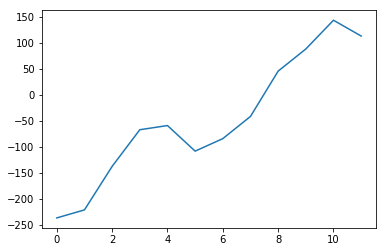

In [3]:
import matplotlib.pyplot as plt
import scipy.misc

%matplotlib inline
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)